The fundamental issue in machine learning is the tension between optimisation and generalisation. A robust fit occurs when the training and validation losses diverge. This is when the model starts to learn details about the training data that are misleading or irrelevent when it comes to the new data. 

Overfitting is likely to occur in noisy data, or mislabelled data ect. Even perfectly labelled data can be noisy if the problem is ambiguous! (e.g when is a banana ripe?) It can be problematic when the model starts to overfit to data in regions that are ambiguous. 

Rare features and spurious correlations also cause overfitting. e.g. in a sentiment classification task if one word is present only once in the training dataset and it is a negative review, a very heavy weighting might be given to it when in reality it could have nothing to do with the review! There could be a data point in 100 samples that is leads to 54% positive, 46% negative reviews, the model would learn this! What if it had nothing to do with the outcome of the review and it was just chance that the 54/46 split is there!

In [9]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zeros_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def get_model():
    model = keras.Sequential([layers.Dense(512, activation="relu"), layers.Dense(10, activation="softmax")])
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

model = get_model()

history_noise = model.fit(train_images_with_noise_channels, train_labels, epochs=10, batch_size=128, validation_split=0.2)

model = get_model()

history_zeros = model.fit(train_images_with_zeros_channels, train_labels, epochs=10, batch_size=128, validation_split=0.2)



Epoch 1/10
375/375 [==============================] - 1s 2ms/step - loss: 0.6362 - accuracy: 0.8099 - val_loss: 0.3625 - val_accuracy: 0.8904
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2506 - accuracy: 0.9226 - val_loss: 0.1934 - val_accuracy: 0.9420
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1650 - accuracy: 0.9487 - val_loss: 0.1533 - val_accuracy: 0.9570
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.1179 - accuracy: 0.9630 - val_loss: 0.1304 - val_accuracy: 0.9617
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0876 - accuracy: 0.9724 - val_loss: 0.1372 - val_accuracy: 0.9614
Epoch 6/10
375/375 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.9797 - val_loss: 0.1439 - val_accuracy: 0.9617
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0.1332 - val_accuracy: 0.9657
Epoch 

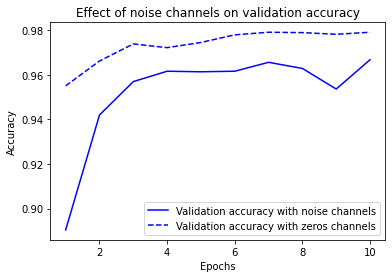

In [11]:
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Though the training data holds exactly the same information in both cases, the validation accuracy of the model trained with the noise performs a percentage point lower purely through the influence of spurious correlations!

This is why it is common to perform feature selection before training. A typical way to do this is to compute some usefulness score for each feature available and only keep features that are above some threshold. Doing this would filter out the while noise channels!

The input to the MNIST classifier is a 28x28 array of integers between 0-255. Thats 784^(256) possiblities! (Greater than the number of atoms in the universe!) Fortunately handwritten digits occupy a small subspace of this parent space, and this subspace is continuous! (Small changes to handwritten digits still count as digits!) Each individual digits subspace are connected by smooth paths. In technical terms, handwritten digits form a manifold within the space of possible 28x28 unit8 arrays. A manifold is a lower-dimensional subspace of some parent space. The manifold hypothesis posits thatl all natural data lies on a low-dimensional manifold within the high-dimensional space where it is encoded. Pretty strong statement!

Within one of these manifolds it should be possible to interpolate between two inputs! (manifold interpolation is not the same as linear interpolation!) The ability to interpolate between samples is fundamental to understanding generalisation in deep learning. This only enables local generalisation, it will not help with things are not close to what is seen in the training dataset. 

For a model top perform well it needs to be trained on a dense sampling of its input space.

One process to fight overfitting is known as regularisation, this involves forcing the optimisation process to focus on the most prominent patterns in the hope that they have a better chance of generalising well. 

General data is split into three sets: training, validation and test. Once a model is ready we test it one final time on the test data, which is meant to be as similiar as possible to production data. This is because developing a model always involves tuning hyperparamters (number of layers, size of layers, learing rate, epochs ect) as well as as the networks actual paramters (its weights). Since we use the validation dataset to evaulate the performance of the model, we want to avoid overfitting to that dataset even though the model has never trained on it. This is down to information leaks, since we evaluate the network on the validation set, everytime we change hyperparameters we are effectively tuning the network to perform artifically well on the validation set!

There are few ways to split data into training, validation and test sets! We will cover simple holdout validation, K-fold validation, and iterated K-fold validation with shuffling. (plus some common-sense baselines!) 

Simple holdout validation

In [12]:
# This is the simplest evaluation protocal. If little data is avaialbe then the validation and test datasets may contain too few samples to represent the data.
# This is easy to recognize! If random shuffles of the data before splitting result on very different model performance metrics we are suffering from this!
# K-fold approaches can deal with this!

num_validation_samples = 10000
np.random.shuffle(data)

validation_data = data[:num_validation_samples]
training_data = data[num_validation_samples:]
model = get_model()
mode.fit(training_data, ...)
validation_score = model.evaluate(validation_data, ...)

# Here we have trained on the training_data, and evalutated on the validation_data. At this point we could tune hyperparameters, retrain it, evalutate it, and continue the cycle. 

...

model = get_model()
model.fit(np.concatenate([training_data, validation_data]), ...) # Once hyperparameters are tuned, its common to train your final model from scratch on alll the non-test data available!
test_score = model.evaluate(test_data, ...)

NameError: name 'data' is not defined

K-fold validation

In [ ]:
# We split our data into K partitions of equal size. For each partition i we train a model on the remaining K-1 partitions, evaluating on partition i. The final score is the average of the K scores. 

k = 3 
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []

for fold in range(k):
    validation_data = data[num_validation_samples * fold:num_validation_samples * (fold + 1)]
    training_data = np.concatenate(data[:num_validation_samples * fold], data[num_validation_samples * (fold + 1):])
    model = get_model()
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)
validation_score = np.average(validation_scores)
model = get_model()
model.fit(data, ...) # trains the final model on all non-test data avaialble!
test_score = model.evaluate(test_data, ...)

Iterated K-fold validation with shuffling

In [ ]:
# This basically consits of applying K-fold validation P times so we end up training K * P models! (Can be very expensive)

Before training on a dataset we should alwaus pick a trivial baseline that we should try to beat! This could be the performance of a random classifier, or a very simple non-machine learning approach.
If data appears more than once in a dataset, if it is randomly shuffled then split into train/validation sets it is possible the same data point exists in both sets. This is very bad! Ensure there is no redundancy in the data!

Playing around with the gradient decent parameters like learning rate and batch size will help models train!

In [ ]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape(60000, 28*28)
train_images = train_images.astype("float32") / 255

model = keras.Sequential([layers.Dense(512, activation="relu"), layers.Dense(10, activation="softmax")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # Here we pass a RMSprop object so we can specify the learning rate! 
model.fit(train_images, train_labels, epochs=10, batch_size=256, validation_split=0.2) # Increasing batch size with more samples means the gradients are more informative and less noisy. 

Epoch 1/10
188/188 [==============================] - 1s 3ms/step - loss: 0.4461 - accuracy: 0.8931 - val_loss: 0.1496 - val_accuracy: 0.9572
Epoch 2/10
188/188 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9621 - val_loss: 0.1331 - val_accuracy: 0.9653
Epoch 3/10
188/188 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9739 - val_loss: 0.1627 - val_accuracy: 0.9571
Epoch 4/10
188/188 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9801 - val_loss: 0.1737 - val_accuracy: 0.9657
Epoch 5/10
188/188 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9823 - val_loss: 0.1471 - val_accuracy: 0.9715
Epoch 6/10
188/188 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9856 - val_loss: 0.1476 - val_accuracy: 0.9744
Epoch 7/10
188/188 [==============================] - 1s 3ms/step - loss: 0.0454 - accuracy: 0.9884 - val_loss: 0.1629 - val_accuracy: 0.9737
Epoch 

What happens if a model will train, but performance on the validation set isn't improving? This indicates something is fundamentally wrong with the approach. It may be that the input data simply doesn't contain sufficient information to predict our targets (e.g. if the labels are randomly shuffled this would happen!) It may also be that the model is not suited to the problem. Using a model that makes the correct assumptions about the problem is important!

Here is a example of a small logistic regression model trained on the MNIST dataset. 

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.6686 - accuracy: 0.8367 - val_loss: 0.3570 - val_accuracy: 0.9058
Epoch 2/20
375/375 [==============================] - 0s 952us/step - loss: 0.3513 - accuracy: 0.9034 - val_loss: 0.3074 - val_accuracy: 0.9158
Epoch 3/20
375/375 [==============================] - 0s 784us/step - loss: 0.3157 - accuracy: 0.9122 - val_loss: 0.2898 - val_accuracy: 0.9190
Epoch 4/20
375/375 [==============================] - 0s 815us/step - loss: 0.2995 - accuracy: 0.9166 - val_loss: 0.2807 - val_accuracy: 0.9212
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2896 - accuracy: 0.9188 - val_loss: 0.2764 - val_accuracy: 0.9247
Epoch 6/20
375/375 [==============================] - 1s 1ms/step - loss: 0.2835 - accuracy: 0.9207 - val_loss: 0.2720 - val_accuracy: 0.9245
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2784 - accuracy: 0.9219 - val_loss: 0.2704 - val_accuracy: 0.9262


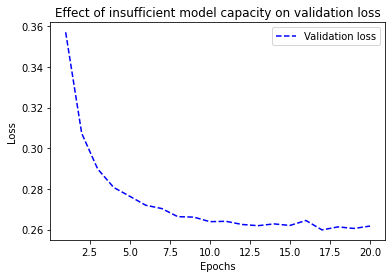

In [17]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_small_model = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

We reach a point where the validation loss stagnates, it is still decreasing, just very slowly! Remember it should always be possible to overtrain on data, and we want to overtrain to find where that border is!

The problem here is likely the representational power of a model. We are going to need a bigger model to be able to store more information. We do this by adding more layers or making layers larger (or both!)

Epoch 1/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.8974 - val_loss: 0.1905 - val_accuracy: 0.9425
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1604 - accuracy: 0.9526 - val_loss: 0.1393 - val_accuracy: 0.9582
Epoch 3/20
375/375 [==============================] - 1s 4ms/step - loss: 0.1149 - accuracy: 0.9650 - val_loss: 0.1236 - val_accuracy: 0.9622
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0876 - accuracy: 0.9731 - val_loss: 0.0997 - val_accuracy: 0.9697
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0705 - accuracy: 0.9791 - val_loss: 0.1125 - val_accuracy: 0.9672
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0573 - accuracy: 0.9823 - val_loss: 0.0917 - val_accuracy: 0.9739
Epoch 7/20
375/375 [==============================] - 1s 1ms/step - loss: 0.0470 - accuracy: 0.9857 - val_loss: 0.0898 - val_accuracy: 0.9750
Epoch 

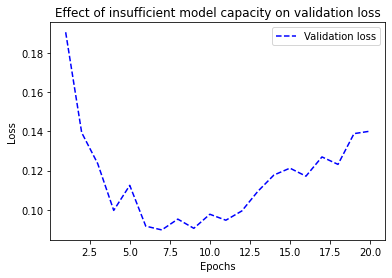

In [19]:
model = keras.Sequential([layers.Dense(96, activation="relu"), layers.Dense(96, activation="relu"), layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_large_model = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Once the model has shown to have some generalisation power and it can overfit to the data, it is time to switch focus to maximising the generalisation of the model.

Here are some tips: Make sure we have enough data, minimise labelling errors, clean the data and deal with missing values, if there are several features and you aren't sure which ones are actually useful, perform feature selection!

Feature engineering is the process of using your own knowledge of the data and the model to improve performance by applying hardcoded (non-learned) transformations to data before it is inputted into the model, making the models job easier! Good features let you solve the problem with dat less data. 

Finding the exact boundary between under and overfitting is one of the best ways to improve generalisation! In Keras we can do this with an EarlyStopping callback, which interupts training as soon as the validation metrics have stopped improving, while remembering the model known model state. More about this in chapter 7!

Reguarlisation techniques are used to impede a models ability to overfit to data. There are a few different regularisation techniques! One is reducing the size of a network, by doing it prevents the network from simply memorising the training data. Combining this approach with ensuring that the model can train means there is a compromise to found between too much and too little capacity. This can be done by adding layers or increasing the size of layers until we see diminishing returns on the validation dataset. Lets try this out on the movie-review classification model from chapter 4!

Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.5222 - accuracy: 0.7867 - val_loss: 0.3925 - val_accuracy: 0.8678
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3121 - accuracy: 0.9002 - val_loss: 0.3074 - val_accuracy: 0.8864
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2286 - accuracy: 0.9263 - val_loss: 0.2839 - val_accuracy: 0.8862
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1786 - accuracy: 0.9395 - val_loss: 0.3136 - val_accuracy: 0.8744
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1456 - accuracy: 0.9544 - val_loss: 0.3136 - val_accuracy: 0.8756
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1217 - accuracy: 0.9619 - val_loss: 0.3256 - val_accuracy: 0.8753
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0976 - accuracy: 0.9705 - val_loss: 0.3290 - val_accuracy: 0.8791
Epoch 8/20
30/30 [=

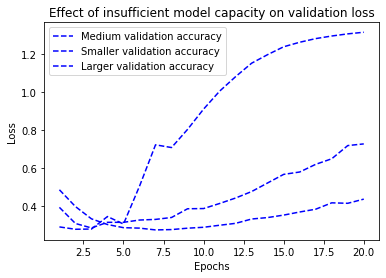

In [5]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt

(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential([layers.Dense(16, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_original = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

model = keras.Sequential([layers.Dense(4, activation="relu"), layers.Dense(4, activation="relu"), layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_smaller = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

model = keras.Sequential([layers.Dense(512, activation="relu"), layers.Dense(512, activation="relu"), layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_larger = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)



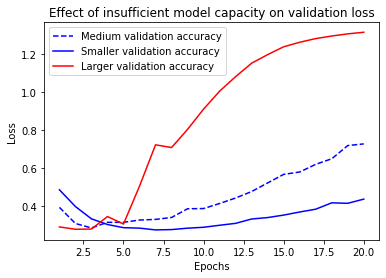

In [6]:
epochs = range(1, 21)
val_loss_original = history_original.history["val_loss"]
val_loss_smaller = history_smaller.history["val_loss"]
val_loss_larger = history_larger.history["val_loss"]
plt.plot(epochs, val_loss_original, "b--", label="Medium validation accuracy")
plt.plot(epochs, val_loss_smaller, "b", label="Smaller validation accuracy")
plt.plot(epochs, val_loss_larger, "r", label="Larger validation accuracy")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

From this plot you can see the smaller model starts overfitting later than the medium sized model, and its performance degrades slower after it starts overfitting. We can also see that there is such a thing as too much memorisation capacity, as seen with the larger model which begins overfitting straight away! 

We can fight this by adding weight regularisation! This basically enforces Occam's razor: the simplest explanation is the most likely to be correct! It does this by penalising larger the size of assigned weights, forcing them to take the smallest value possible. This is done by adding a loss function which applies a cost to the size of weights, either L1, L2 norm or any other! (L2 is also sometimes called weight decay). In Keras weight regulisation is performed by passing weight regulariser instances to layers as keywork arguments. 

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6194 - accuracy: 0.7760 - val_loss: 0.4904 - val_accuracy: 0.8650
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4226 - accuracy: 0.8906 - val_loss: 0.4187 - val_accuracy: 0.8722
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3500 - accuracy: 0.9129 - val_loss: 0.3891 - val_accuracy: 0.8786
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3143 - accuracy: 0.9219 - val_loss: 0.3636 - val_accuracy: 0.8888
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2894 - accuracy: 0.9313 - val_loss: 0.3600 - val_accuracy: 0.8880
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2774 - accuracy: 0.9313 - val_loss: 0.3610 - val_accuracy: 0.8861
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2653 - accuracy: 0.9376 - val_loss: 0.3635 - val_accuracy: 0.8836
Epoch 8/20
30/30 [=

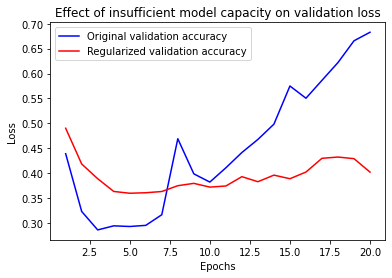

In [8]:
from tensorflow.keras import regularizers

model = keras.Sequential([layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"), layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"), layers.Dense(1, activation="sigmoid")])

# kernal_regularizer=regularizers.l2(0.002) means the layer will add 0.002 * weight_coefficient_value ** 2 to the total loss of the model. This is only added during training!

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_regularized = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

model = keras.Sequential([layers.Dense(16, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_original = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

val_loss_original = history_original.history["val_loss"]
val_loss_regularized = history_regularized.history["val_loss"]
plt.plot(epochs, val_loss_original, "b", label="Original validation accuracy")
plt.plot(epochs, val_loss_regularized, "r", label="Regularized validation accuracy")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

As we can see in the figure above, the L2 regularization has made the model much more resistant to overfitting! There are also the following regularizers in keras: regularizers.l1(0.001) regularizers.l1_l2(l1=0.001, l2=0.001) (you can apply both l1 and l2 at the same time!) Typically regularization is used for smaller models, large models tend to be overparameterised so apply constraints to weights doesn't really work. In this case another approach is preffered: dropout! Droput is the process of randomly setting to zero a number of output features of a layer during training. The dropout rate is the fraction of features that are zeroed out, and is usually set between 0.2 and 0.5! At test time no units are dropped out, instead the layers output values are scaled down by a factor equal to the dropout rate to balance for the fact that more units are active than during training time. In keras, dropout is implemented with a dropout layer which is applied to the output of the layer right before it. Lets add two dropout layers to the model and see what happens! 

In [9]:
model = keras.Sequential([layers.Dense(16, activation="relu"), layers.Dropout(0.5), layers.Dense(16, activation="relu"), layers.Dropout(0.5), layers.Dense(1, activation="sigmoid")])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history_dropout = model.fit(train_data, train_labels, epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 26ms/step - loss: 0.6442 - accuracy: 0.6329 - val_loss: 0.5567 - val_accuracy: 0.8380
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.5469 - accuracy: 0.7597 - val_loss: 0.4509 - val_accuracy: 0.8570
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.4625 - accuracy: 0.8131 - val_loss: 0.3815 - val_accuracy: 0.8806
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4056 - accuracy: 0.8537 - val_loss: 0.3378 - val_accuracy: 0.8878
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.3533 - accuracy: 0.8814 - val_loss: 0.3019 - val_accuracy: 0.8913
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3138 - accuracy: 0.8997 - val_loss: 0.2910 - val_accuracy: 0.8936
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2789 - accuracy: 0.9143 - val_loss: 0.2867 - val_accuracy: 0.8924
Epoch 8/20
30/

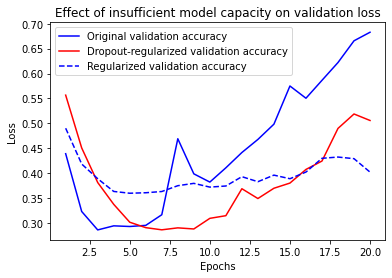

In [11]:
val_loss_original = history_original.history["val_loss"]
val_loss_dropout = history_dropout.history["val_loss"]
plt.plot(epochs, val_loss_original, "b", label="Original validation accuracy")
plt.plot(epochs, val_loss_dropout, "r", label="Dropout-regularized validation accuracy")
plt.plot(epochs, val_loss_regularized, "b--", label="Regularized validation accuracy")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

It seems to be a clear improvement over the original model, and also out performs the L2 regularized model as it acheives a lower lowest validation loss!

To recap, the most common ways to maximize generalisation and prevernt overfitting in neural networks is:
- Get more training data, or better training data
- Develop better features with feature engineering
- Reduce the capacity of the model
- Add weight regularization (for smaller models)
- Add dropout